In [0]:
!unzip spoken-digit-dataset.zip

In [0]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import librosa

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir(r"free-spoken-digit-dataset-master"))

# Any results you write to the current directory are saved as output.

['recordings', 'metadata.py', 'pip_requirements.txt', 'utils', 'README.md', 'acquire_data', 'free-spoken-digit-dataset-master', '__init__.py', '.gitignore']


In [0]:
from keras.utils import to_categorical
from tqdm import tqdm

def wav2mfcc(file_path, augment = False, max_pad_len=11):
    wave, sr = librosa.load(file_path, mono=True, sr=8000, duration = 1.024)
    
    if augment == True:
        bins_per_octave = 12
        pitch_pm = 4
        pitch_change =  pitch_pm * 2*(np.random.uniform())   
        wave = librosa.effects.pitch_shift(wave, 
                                          8000, n_steps=pitch_change, 
                                          bins_per_octave=bins_per_octave)
        
        speed_change = np.random.uniform(low=0.9,high=1.1)
        wave = librosa.effects.time_stretch(wave, speed_change)
        wave = wave[:8192]

    duration = wave.shape[0]/sr
    speed_change = 2.0* duration/1.024
    wave = librosa.effects.time_stretch(wave, speed_change)
    wave = wave[:4096]
    
    wave = librosa.util.normalize(wave)
    mfcc = librosa.feature.mfcc(wave, sr=sr, n_mfcc=40, hop_length=int(0.048*sr), n_fft=int(0.096*sr))
    mfcc -= (np.mean(mfcc, axis=0) + 1e-8)
    #print("shape=",mfcc.shape[1], wave.shape[0])
    pad_width = max_pad_len - mfcc.shape[1]
    mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    #mfcc = mfcc[2:24,:]
    return mfcc, duration, sr

def get_data(dir = '', augment= False):
    labels = []
    mfccs = []
    durations = []
    sampling_rates = []
    filenames = []

    for f in tqdm(os.listdir(dir)):
        if f.endswith('.wav'):
            mfcc, duration, sr = wav2mfcc(dir + "/" + f, augment)
            mfccs.append(mfcc)
            durations.append(duration)
            sampling_rates.append(sr)
            # List of labels
            label = f.split('_')[0]
            labels.append(label)
            filenames.append(dir + "/" + f)
    return filenames, np.asarray(mfccs), np.asarray(durations), np.asarray(sampling_rates), to_categorical(labels), labels

Using TensorFlow backend.


In [0]:
filenames, mfccs, durations, sampling_rates, labels, cls_true = get_data('free-spoken-digit-dataset-master/free-spoken-digit-dataset-master/recordings')

100%|██████████| 1500/1500 [03:28<00:00,  7.15it/s]


In [0]:
import matplotlib.pyplot as plt
import librosa.display

def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3, figsize=(15,15))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    max = np.max(images)
    min = np.min(images)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        #ax.imshow(images[i].reshape(img_shape), cmap='binary')
        im = librosa.display.specshow(images[i], ax=ax, vmin=min, vmax=max)

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

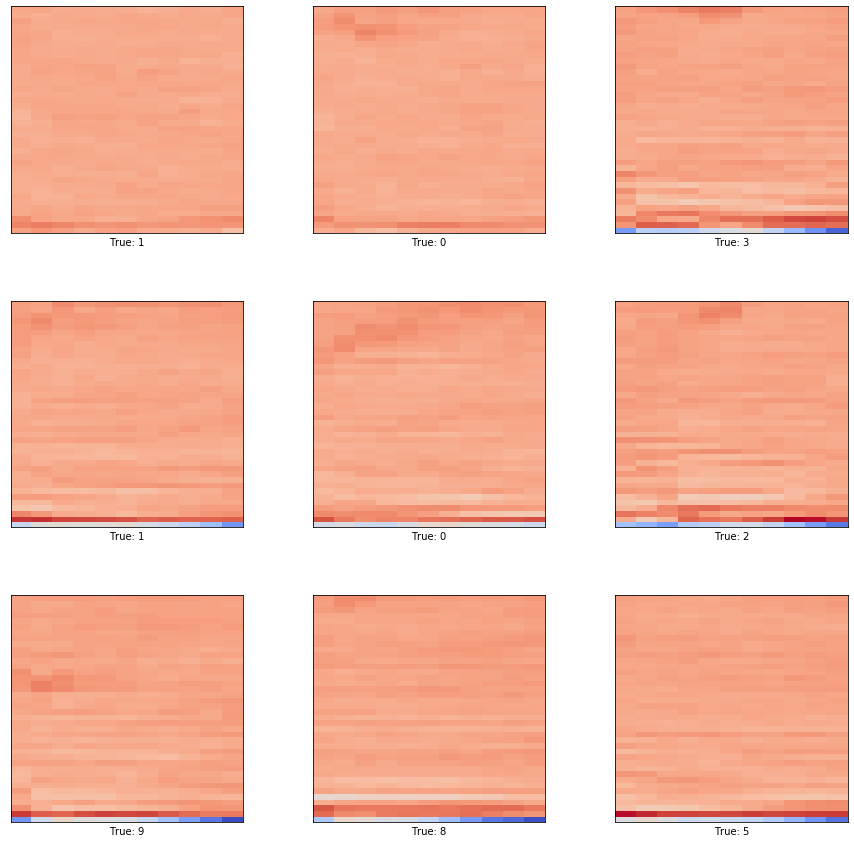

In [0]:
plot_images(mfccs[100:109], cls_true[100:109])

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization

#from ann_visualizer.visualize import ann_viz

def get_cnn_model(input_shape, num_classes):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=(4, 4), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())

    model.add(Conv2D(48, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())

    model.add(Conv2D(120, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])

    return model

In [0]:
from sklearn.model_selection import train_test_split

def get_all():
    filenames, mfccs, durations, sampling_rates, labels, cls_true = get_data('free-spoken-digit-dataset-master/free-spoken-digit-dataset-master/recordings', augment = False)
    
    filenames_a, mfccs_a, durations_a, sampling_rates_a, labels_a, cls_true_a = get_data('free-spoken-digit-dataset-master/free-spoken-digit-dataset-master/recordings', augment = True)

    mfccs = np.append(mfccs, mfccs_a, axis=0)
    labels = np.append(labels, labels_a, axis =0)
    
    dim_1 = mfccs.shape[1]
    dim_2 = mfccs.shape[2]
    channels = 1
    classes = 10
    
    print("sampling rate (max) = ", np.max(sampling_rates))
    print("sampling rate (min) = ", np.min(sampling_rates))
    print("duration (max) = ", np.max(durations))
    print("duration (avg) = ", np.average(durations))
    print("duration (min) = ", np.min(durations))
    print("mffc matrix = ", mfccs.shape)

    X = mfccs
    X = X.reshape((mfccs.shape[0], dim_1, dim_2, channels))
    y = labels

    input_shape = (dim_1, dim_2, channels)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

    model = get_cnn_model(input_shape, classes)

    return X_train, X_test, y_train, y_test, model

In [0]:
X_train, X_test, y_train, y_test, cnn_model = get_all()

print(cnn_model.summary())


In [0]:

cnn_model.fit(X_train, y_train, batch_size=64, epochs=500, verbose=1, validation_split=0.1)

Train on 2160 samples, validate on 240 samples
Epoch 1/500
2160/2160 [==============================] - 6s 3ms/step - loss: 0.1103 - acc: 0.9727 - val_loss: 0.3494 - val_acc: 0.8792
Epoch 2/500
2160/2160 [==============================] - 6s 3ms/step - loss: 0.0940 - acc: 0.9787 - val_loss: 0.2387 - val_acc: 0.9083
Epoch 3/500
2160/2160 [==============================] - 6s 3ms/step - loss: 0.0699 - acc: 0.9838 - val_loss: 0.2274 - val_acc: 0.9292
Epoch 4/500
2160/2160 [==============================] - 6s 3ms/step - loss: 0.0682 - acc: 0.9819 - val_loss: 0.2784 - val_acc: 0.9083
Epoch 5/500
2160/2160 [==============================] - 6s 3ms/step - loss: 0.0652 - acc: 0.9838 - val_loss: 0.3074 - val_acc: 0.8958
Epoch 6/500
2160/2160 [==============================] - 6s 3ms/step - loss: 0.0534 - acc: 0.9861 - val_loss: 0.2019 - val_acc: 0.9333
Epoch 7/500
2160/2160 [==============================] - 6s 3ms/step - loss: 0.0543 - acc: 0.9866 - val_loss: 0.2791 - val_acc: 0.9208
Epoch 8/

In [0]:
print(X_test.shape)
print(y_test.shape)

(600, 40, 11, 1)
(600, 10)


In [0]:
np.save("X_train",X_train.reshape(-1,40*11))
np.save("y_train",np.array([np.argmax(u) for u in y_train]))

np.save("y_test",np.array([np.argmax(u) for u in y_test]))

np.save("X_test",X_test.reshape(-1,40*11))
X = np.concatenate((X_train, X_test))
y=np.concatenate((y_train, y_test))
np.save("X",X)
np.save("y",y)

In [0]:
import numpy as np
from numpy import linalg as LA
import random
import math, sys
import sklearn
import numexpr as ne
from sklearn.decomposition import PCA
from sklearn.kernel_approximation import Nystroem, RBFSampler
from sklearn.preprocessing import label_binarize
from sklearn.cluster import KMeans
import datetime
import time
from sklearn.model_selection import train_test_split
np.set_printoptions(precision=4, suppress=True, threshold=1000, linewidth=500)
ne.set_num_threads(32)
random.seed(1)

def zca_whitening(inputs):
    inputs -= np.mean(inputs, axis=0)
    sigma = np.dot(inputs.T, inputs)/inputs.shape[0]
    U,S,V = np.linalg.svd(sigma)
    epsilon = 0.1
    ZCAMatrix = np.dot(np.dot(U, np.diag(1.0/np.sqrt(S + epsilon))), U.T).astype(np.float32)

    i = 0
    while i < inputs.shape[0]:
        next_i = min(inputs.shape[0], i+100000)
        inputs[i:next_i] = np.dot(inputs[i:next_i], ZCAMatrix.T)
        i = next_i

    return inputs

class NystroemTransformer:
    reference_matrix = 0
    transform_matrix = 0
    n_components = 0
    gamma = 0

    def __init__(self, gamma, n_components):
        self.n_components = n_components
        self.gamma = gamma

    def fit(self, X):
        n = X.shape[0]
        index = np.random.randint(0, n, self.n_components)
        self.reference_matrix = np.copy(X[index])
        kernel_matrix = rbf_kernel_matrix(gamma=self.gamma, X=self.reference_matrix, Y=self.reference_matrix)
        (U, s, V) = LA.svd(kernel_matrix)
        self.transform_matrix = np.dot(U, np.dot(np.diag(1.0/np.sqrt(s)), V))

    def transform(self, Y):
        kernel_matrix = rbf_kernel_matrix(gamma=self.gamma, X=self.reference_matrix, Y=Y)
        output = (np.dot(self.transform_matrix, kernel_matrix)).T
        return output

class RandomFourierTransformer:
    transform_matrix = 0
    transform_bias = 0
    n_components = 0
    gamma = 0

    def __init__(self, gamma, n_components):
        self.n_components = n_components
        self.gamma = gamma

    def fit(self, X):
        d = X.shape[1]
        self.transform_matrix = np.random.normal(loc=0, scale=math.sqrt(2*self.gamma), size=(d, self.n_components)).astype(np.float32)
        self.transform_bias = (np.random.rand(1, self.n_components) * 2 * math.pi).astype(np.float32)

    def transform(self, Y):
        ny = Y.shape[0]
        angle = np.dot(Y, self.transform_matrix)
        bias = self.transform_bias
        factor = np.float32(math.sqrt(2.0 / self.n_components))
        return ne.evaluate("factor*cos(angle+bias)")

def rbf_kernel_matrix(gamma, X, Y):
    nx = X.shape[0]
    ny = Y.shape[0]
    X2 = np.dot(np.sum(np.square(X), axis=1).reshape((nx, 1)), np.ones((1,ny), dtype=np.float32))
    Y2 = np.dot(np.ones((nx,1), dtype=np.float32), np.sum(np.square(Y), axis=1).reshape((1, ny)))
    XY = np.dot(X, Y.T)
    return ne.evaluate("exp(gamma*(2*XY-X2-Y2))")

def tprint(s):
    tm_str = time.strftime("%H:%M:%S", time.gmtime(time.time()))
    print(tm_str + ":  " + str(s))
    sys.stdout.flush()

def safe_exp(X):
    return np.exp(np.maximum(np.minimum(X, 20), -20))

def normalize_vec(v):
    norm = LA.norm(v)
    if norm > 0:
        return v / norm
    else:
        return v

def euclidean_proj_simplex(v, s=1):
    """ Compute the Euclidean projection on a positive simplex
    Solves the optimisation problem (using the algorithm from [1]):
        min_w 0.5 * || w - v ||_2^2 , s.t. \sum_i w_i = s, w_i >= 0
    Parameters
    ----------
    v: (n,) numpy array,
       n-dimensional vector to project
    s: int, optional, default: 1,
       radius of the simplex
    Returns
    -------
    w: (n,) numpy array,
       Euclidean projection of v on the simplex
    Notes
    -----
    The complexity of this algorithm is in O(n log(n)) as it involves sorting v.
    Better alternatives exist for high-dimensional sparse vectors (cf. [1])
    However, this implementation still easily scales to millions of dimensions.
    References
    ----------
    [1] Efficient Projections onto the .1-Ball for Learning in High Dimensions
        John Duchi, Shai Shalev-Shwartz, Yoram Singer, and Tushar Chandra.
        International Conference on Machine Learning (ICML 2008)
        http://www.cs.berkeley.edu/~jduchi/projects/DuchiSiShCh08.pdf
    """
    assert s > 0, "Radius s must be strictly positive (%d <= 0)" % s
    n, = v.shape  # will raise ValueError if v is not 1-D
    # check if we are already on the simplex
    if v.sum() == s and np.alltrue(v >= 0):
        # best projection: itself!
        return v
    # get the array of cumulative sums of a sorted (decreasing) copy of v
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u)
    # get the number of > 0 components of the optimal solution
    rho = np.nonzero(u * np.arange(1, n+1) > (cssv - s))[0][-1]
    # compute the Lagrange multiplier associated to the simplex constraint
    theta = (cssv[rho] - s) / (rho + 1.0)
    # compute the projection by thresholding v using theta
    w = (v - theta).clip(min=0)
    return w

def euclidean_proj_l1ball(v, s=1):
    """ Compute the Euclidean projection on a L1-ball
    Solves the optimisation problem (using the algorithm from [1]):
        min_w 0.5 * || w - v ||_2^2 , s.t. || w ||_1 <= s
    Parameters
    ----------
    v: (n,) numpy array,
       n-dimensional vector to project
    s: int, optional, default: 1,
       radius of the L1-ball
    Returns
    -------
    w: (n,) numpy array,
       Euclidean projection of v on the L1-ball of radius s
    Notes
    -----
    Solves the problem by a reduction to the positive simplex case
    See also
    --------
    euclidean_proj_simplex
    """
    assert s > 0, "Radius s must be strictly positive (%d <= 0)" % s
    n, = v.shape  # will raise ValueError if v is not 1-D
    # compute the vector of absolute values
    u = np.abs(v)
    # check if v is already a solution
    if u.sum() <= s:
        # L1-norm is <= s
        return v
    # v is not already a solution: optimum lies on the boundary (norm == s)
    # project *u* on the simplex
    w = euclidean_proj_simplex(u, s=s)
    # compute the solution to the original problem on v
    w *= np.sign(v)
    return w

def get_pixel_vector(center_x, center_y, radius, image_width):
    size = int(radius * 2 + 1)
    vector = np.zeros(size*size, dtype=int)
    for y in range(0, size):
        for x in range(0, size):
            index = (center_x+x-radius) + (center_y+y-radius) * image_width
            vector[x+y*size] = index
    return vector

def get_pixel_index_matrix(center_x, center_y, radius, image_width):
    size = (radius * 2 + 1)*(radius * 2 + 1)
    matrix = np.zeros((size, size), dtype=int)
    for y in range(0, 2*radius+1):
        for x in range(0, 2*radius+1):
            cursor_x = center_x+x-radius
            cursor_y = center_y+y-radius
            matrix[x+y*(2*radius+1)] = get_pixel_vector(cursor_x, cursor_y, radius, image_width)
    return matrix

def project_to_low_rank(A, rank, d1, d2):
    A = np.reshape(A, (9*d1, d2))
    (U, s, V) = LA.svd(A, full_matrices=False)
    s[rank:] *= 0
    return np.reshape(np.dot(U, np.dot(np.diag(s), V)), (9, d1*d2)), U, s, V

def project_to_trace_norm(A, trace_norm, d1, d2):
    A = np.reshape(A, (9*d1, d2))
    (U, s, V) = LA.svd(A, full_matrices=False)
    s = euclidean_proj_l1ball(s, s=trace_norm)
    return np.reshape(np.dot(U, np.dot(np.diag(s), V)), (9, d1*d2)), U, s, V

def project_to_trace_regularizer(A, trace_regularizer, d1, d2):
    A = np.reshape(A, (9*d1, d2))
    (U, s, V) = LA.svd(A, full_matrices=False)
    s = np.maximum(s-trace_regularizer, 0)
    return np.reshape(np.dot(U, np.dot(np.diag(s), V)), (9, d1*d2)), U, s, V

def evaluate_classifier(X_train, X_test, Y_train, Y_test, A):
    n_train = X_train.shape[0]
    n_test = X_test.shape[0]
    eXAY = np.exp(np.sum((np.dot(X_train, A.T)) * Y_train[:,0:9], axis=1)) # batch_size-9
    eXA_sum = np.sum(np.exp(np.dot(X_train, A.T)), axis=1) + 1
    loss = - np.average(np.log(eXAY/eXA_sum))

    predict_train = np.concatenate((np.dot(X_train, A.T), np.zeros((n_train, 1), dtype=np.float32)), axis=1)
    predict_test = np.concatenate((np.dot(X_test, A.T), np.zeros((n_test, 1), dtype=np.float32)), axis=1)

    error_train = np.average(np.argmax(predict_train, axis=1) != np.argmax(Y_train, axis=1).astype(int))
    error_test = np.average(np.argmax(predict_test, axis=1) != np.argmax(Y_test, axis=1).astype(int))

    return loss, error_train, error_test

def random_crop(X, d1, d2, radio):
    n = X.shape[0]
    size = int(math.sqrt(d1))
    cropped_size = int(size*radio)
    X = X.reshape((n, size, size, d2))
    X_cropped = np.zeros((n, cropped_size, cropped_size, d2), dtype=np.float32)
    for i in range(n):
        y = np.random.randint(size - cropped_size + 1)
        x = np.random.randint(size - cropped_size + 1)
        X_cropped[i] = X[i, y:y+cropped_size, x:x+cropped_size]
    return X_cropped.reshape((n, cropped_size*cropped_size*d2))

def central_crop(X, d1, d2, radio):
    n = X.shape[0]
    size = int(math.sqrt(d1))
    cropped_size = int(size*radio)
    X = X.reshape((n, size, size, d2))
    begin = int((size-cropped_size)/2)
    return X[:,begin:begin+cropped_size, begin:begin+cropped_size].reshape((n, cropped_size*cropped_size*d2))

def low_rank_matrix_regression(X_train, Y_train, X_test, Y_test, d1, d2, reg, n_iter, learning_rate, ratio):
    n_train = X_train.shape[0]
    cropped_d1 = int(d1*ratio*ratio)
    A = np.zeros((9, cropped_d1*d2), dtype=np.float32) # 9-(d1*d2)
    A_sum = np.zeros((9, cropped_d1*d2), dtype=np.float32) # 9-(d1*d2)
    computation_time = 0

    for t in range(n_iter):
        mini_batch_size = 50
        batch_size = 10

        start = time.time()
        for i in range(0, batch_size):
            index = np.random.randint(0, n_train, mini_batch_size)
            X_sample = random_crop(X_train[index], d1, d2, ratio) # batch-(d1*d2)
            Y_sample = Y_train[index, 0:9] # batch-9

            # stochastic gradient descent
            XA = np.dot(X_sample, A.T)
            eXA = ne.evaluate("exp(XA)")
            # eXA = np.exp(XA)
            eXA_sum = np.sum(eXA, axis=1).reshape((mini_batch_size, 1)) + 1
            diff = ne.evaluate("eXA/eXA_sum - Y_sample")
            grad_A = np.dot(diff.T, X_sample) / mini_batch_size
            # grad_A = np.dot((eXA/eXA_sum - Y_sample).T, X_sample) / mini_batch_size
            A -= learning_rate * grad_A

        # projection to trace norm ball
        A, U, s, V = project_to_trace_norm(A, reg, cropped_d1, d2)
        end = time.time()
        computation_time += end - start

        A_sum += A
        if (t+1) % 250 == 0:
            dim = np.sum(s[0:25]) / np.sum(s)
            A_avg = A_sum / 250
            loss, error_train, error_test = evaluate_classifier(central_crop(X_train, d1, d2, ratio),
                                                                central_crop(X_test, d1, d2, ratio), Y_train, Y_test, A_avg)
            A_sum = np.zeros((9, cropped_d1*d2), dtype=np.float32)

            # debug
            tprint("iter " + str(t+1) + ": loss=" + str(loss) + ", train=" + str(error_train) + ", test=" + str(error_test) + ", dim=" + str(dim))
            # print(str(computation_time) + "\t" + str(error_test))

    A_avg, U, s, V = project_to_trace_norm(np.reshape(A_avg, (9*cropped_d1, d2)), reg, cropped_d1, d2)
    dim = min(np.sum((s > 0).astype(int)), 25)
    return V[0:dim]

def transform_and_pooling(patch, transformer, selected_group_size, gamma, nystrom_dim,
                                  patch_per_side, pooling_size, pooling_stride):
    n = patch.shape[0]
    patch_per_image = patch.shape[1]
    selected_channel_num = patch.shape[2]
    pixel_per_patch = patch.shape[3]
    group_num = len(selected_group_size)
    feature_dim = group_num * nystrom_dim

    # construct Nystroem transformer
    patch = patch.reshape((n*patch_per_image, selected_channel_num, pixel_per_patch))
    psi = np.zeros((n*patch_per_image, group_num, nystrom_dim), dtype=np.float32)
    if transformer[0] == 0:
        transformer = np.empty(group_num, dtype=object)
        sum = 0
        for i in range(group_num):
            # transformer[i] = NystroemTransformer(gamma=gamma, n_components=nystrom_dim)
            transformer[i] = RandomFourierTransformer(gamma=gamma, n_components=nystrom_dim)
            sub_patch = patch[:, sum:sum+selected_group_size[i]].reshape((n*patch_per_image, selected_group_size[i]*pixel_per_patch)) / math.sqrt(selected_group_size[i])

            transformer[i].fit(X=sub_patch)
            sum += selected_group_size[i]

    # Nystrom transformation
    sum = 0
    for i in range(group_num):
        sub_patch = patch[:, sum:sum+selected_group_size[i]].reshape((n*patch_per_image, selected_group_size[i]*pixel_per_patch)) / math.sqrt(selected_group_size[i])
        psi[:, i] = transformer[i].transform(Y=sub_patch)
        sum += selected_group_size[i]
    psi = psi.reshape((n, patch_per_image, feature_dim))

    # pooling
    pooling_per_side = int(patch_per_side/pooling_stride)
    pooling_per_image = pooling_per_side * pooling_per_side
    psi_pooling = np.zeros((n, pooling_per_image, feature_dim), dtype=np.float32)

    for pool_y in range(0, pooling_per_side):
        range_y = np.array(range(pool_y*pooling_stride, min(pool_y*pooling_stride+pooling_size, patch_per_side)))
        for pool_x in range(0, pooling_per_side):
            range_x = np.array(range(pool_x*pooling_stride, min(pool_x*pooling_stride+pooling_size, patch_per_side)))
            pooling_id = pool_x + pool_y * pooling_per_side
            index = []
            for y in range_y:
                for x in range_x:
                    index.append(x + y*patch_per_side)
            psi_pooling[:, pooling_id] = np.average(psi[:, np.array(index)], axis=1)

    return psi_pooling, transformer

def generate_next_layer(input_file, output_file, label_file, n_train, n_test,
                        patch_radius=2,
                        nystrom_dim=200,
                        pooling_size=2,
                        pooling_stride=2,
                        gamma=2,
                        regularization_param=100,
                        learning_rate=0.2,
                        crop_ratio=1,
                        n_iter=5000,
                        chunk_size=5000,
                        max_channel=16,
                        generate_new_feature = True
                        ):

    tprint("read from " + input_file)
   
   
    if input_file.endswith(".image"):
       
       
        X_train = np.load("X_train.npy")
        X_train=X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))

        X_test = np.load("X_test.npy")
        X_test=X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

        
        X_raw = np.concatenate((X_train, X_test))
        label = np.concatenate((np.load("y_train.npy"), np.load("y_test.npy")))
    else:
        X_raw = np.load(open(input_file + ".npy", "rb"))
        X_raw = X_raw[0:n_train+n_test]
        label = np.concatenate((np.load("y_train.npy"), np.load("y_test.npy")))
    n = n_train + n_test

    # detecting image parameters
    pixel_per_image = X_raw.shape[2]
    pixel_per_side = int(math.sqrt(pixel_per_image))
    patch_per_side = int(pixel_per_side - 2 * patch_radius)
    patch_per_image = patch_per_side * patch_per_side
    patch_size = patch_radius * 2 + 1
    pixel_per_patch = patch_size * patch_size
    pooling_per_side = int(patch_per_side/pooling_stride)
    pooling_per_image = pooling_per_side * pooling_per_side
    tprint("Raw size = " + str(X_raw.shape))

    n_channel = min(max_channel, X_raw.shape[1])
    selected_channel_list = range(0, n_channel)
    selected_group_size = [n_channel]
    tprint(selected_channel_list)
    tprint(selected_group_size)
    feature_dim = len(selected_group_size)*nystrom_dim

    if generate_new_feature == True:
        # construct patches
        tprint("Construct patches...")
        patch = np.zeros((n, patch_per_image, len(selected_channel_list), pixel_per_patch), dtype=np.float32)
        for y in range(0, patch_per_side):
            for x in range(0, patch_per_side):
                for i in selected_channel_list:
                    indices = get_pixel_vector(x + patch_radius, y + patch_radius, patch_radius, pixel_per_side)
                    patch_id = x + y * patch_per_side
                    patch[:, patch_id, i] = X_raw[:, selected_channel_list[i], indices]

        tprint("Patch size = " + str(patch.shape))

        # local contrast normalization and ZCA whitening
        tprint('local contrast normalization and ZCA whitening...')
        patch = patch.reshape((n*patch_per_image, n_channel*pixel_per_patch))
        patch -= np.mean(patch, axis=1).reshape((patch.shape[0], 1))
        patch /= LA.norm(patch, axis=1).reshape((patch.shape[0], 1)) + 0.1
        patch = zca_whitening(patch)
        patch = patch.reshape((n, patch_per_image, n_channel, pixel_per_patch))

        # create features
        tprint("Create features...")
        transformer = [0]
        base = 0
        X_reduced = np.zeros((n, pooling_per_image, feature_dim), dtype=np.float32)
        while base < n:
            tprint ("  sample id " + str(base) + "-" + str(min(n, base+chunk_size)))
            X_reduced[base:min(n, base+chunk_size)], transformer = transform_and_pooling(patch=patch[base:min(n, base+chunk_size)],
                    transformer=transformer, selected_group_size=selected_group_size, gamma=gamma,
                    nystrom_dim=nystrom_dim, patch_per_side=patch_per_side, pooling_size=pooling_size, pooling_stride=pooling_stride)
            base = min(n, base+chunk_size)

        # normalization
        X_reduced = X_reduced.reshape((n*pooling_per_image, feature_dim))
        X_reduced -= np.mean(X_reduced, axis=0)
        X_reduced /= LA.norm(X_reduced) / math.sqrt(n*pooling_per_image)
        X_reduced = X_reduced.reshape((n, pooling_per_image*feature_dim))

        # tprint("Saving features to hard disk...")
        # np.save(input_file+".tmp", X_reduced)

    else:
        tprint("Loading features from hard disk...")
        X_reduced = np.load(open(input_file + ".tmp.npy", "rb"))

    # Learning_filters
    tprint("Training...")
    binary_label = label_binarize(label, classes=range(0, 10))
    filter = low_rank_matrix_regression(X_train=X_reduced[0:n_train], Y_train=binary_label[0:n_train], X_test=X_reduced[n_train:],
                        Y_test=binary_label[n_train:], d1=pooling_per_image, d2=feature_dim,
                        n_iter=n_iter, reg=regularization_param, learning_rate=learning_rate, ratio=crop_ratio)

    filter_dim = filter.shape[0]
    tprint("Apply filters...")
    output = np.dot(X_reduced.reshape((n*pooling_per_image, feature_dim)), filter.T)
    output = np.reshape(output, (n, pooling_per_image, filter_dim))
    output = np.transpose(output, (0, 2, 1))

    tprint("feature dimension = " + str(output[0].size))
    tprint("save to " + output_file)
    np.save(output_file, output)

name = 'mnist_basic'
tprint("name = " + name)
tprint("==========")
global_n_train = len(np.load("X_train.npy"))
global_n_test = len(np.load("X_test.npy"))

generate_next_layer(n_train=global_n_train, n_test=global_n_test, input_file=name+".image", output_file=name+".feature1", label_file=name+".label",
                    chunk_size=100, gamma=0.2, nystrom_dim=500, regularization_param=200,
                    learning_rate=0.2, n_iter=1000, generate_new_feature=True)

generate_next_layer(n_train=global_n_train, n_test=global_n_test, input_file=name+".feature1", output_file=name+".feature2", label_file=name+".label",
                    chunk_size=100, gamma=2, nystrom_dim=1000, regularization_param=500,
                    learning_rate=1, n_iter=2000, generate_new_feature=True)

18:46:49:  name = mnist_basic
18:46:49:  ==========
18:46:49:  read from mnist_basic.image
18:46:49:  Raw size = (3000, 1, 440)
18:46:49:  range(0, 1)
18:46:49:  [1]
18:46:49:  Construct patches...
18:46:50:  Patch size = (3000, 256, 1, 25)
18:46:50:  local contrast normalization and ZCA whitening...
18:46:50:  Create features...
18:46:50:    sample id 0-100
18:46:51:    sample id 100-200
18:46:51:    sample id 200-300
18:46:51:    sample id 300-400
18:46:51:    sample id 400-500
18:46:52:    sample id 500-600
18:46:52:    sample id 600-700
18:46:52:    sample id 700-800
18:46:52:    sample id 800-900
18:46:53:    sample id 900-1000
18:46:53:    sample id 1000-1100
18:46:53:    sample id 1100-1200
18:46:53:    sample id 1200-1300
18:46:53:    sample id 1300-1400
18:46:54:    sample id 1400-1500
18:46:54:    sample id 1500-1600
18:46:54:    sample id 1600-1700
18:46:54:    sample id 1700-1800
18:46:55:    sample id 1800-1900
18:46:55:    sample id 1900-2000
18:46:55:    sample id 2000-2

In [0]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import validation_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

classifier = SVC(kernel='rbf',probability=True)


# Split data into train and test subsets


# We learn the digits on the first half of the digits
classifier.fit(X_train.reshape(-1,40*11), np.array([np.argmax(u) for u in y_train]))
print(classifier.score(X_test.reshape(-1,40*11), np.array([np.argmax(u) for u in y_test])))


0.9116666666666666


In [0]:
def cross_entropy(predictions, targets, epsilon=1e-12):
    """
    Computes cross entropy between targets (encoded as one-hot vectors)
    and predictions. 
    Input: predictions (N, k) ndarray
           targets (N, k) ndarray        
    Returns: scalar
    """
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    N = predictions.shape[0]
    ce = -np.sum(targets*np.log(predictions+1e-9))/N
    return ce


In [0]:
cross_entropy(classifier.predict_proba(X_test.reshape(-1,40*11)), y_test, epsilon=1e-12)

0.2509382589112557